In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# cnn model vary kernel size
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from matplotlib import pyplot

from tensorflow.keras.utils import to_categorical
import tensorflow.keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Dropout, Flatten, Reshape, LSTM, Conv1D, MaxPooling1D, Bidirectional, ConvLSTM1D
from tensorflow.keras.layers import Input, TimeDistributed, Conv1D, MaxPooling1D, BatchNormalization, GlobalAveragePooling1D, Activation
from tensorflow.python.keras.utils import np_utils
from sklearn.metrics import precision_score, recall_score, f1_score
from typing import Any, Dict, List, Tuple
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns


def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values



# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = np.dstack(loaded)
    return loaded

# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y


# load the dataset, returns train and test X and y elements
# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + '/content/drive/MyDrive/UCI HAR Dataset/')
    # load all test
    testX, testy = load_dataset_group('test', prefix + '/content/drive/MyDrive/UCI HAR Dataset/')

    #zero-offset class values
    trainy = trainy - 1
    testy = testy - 1

    trainy_one_hot = to_categorical(trainy)
    testy_one_hot = to_categorical(testy)
    print(trainX.shape, trainy.shape, trainy_one_hot.shape, testX.shape, testy.shape, testy_one_hot.shape)
    return trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot



In [4]:

trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot = load_dataset()

(7352, 128, 9) (7352, 1) (7352, 6) (2947, 128, 9) (2947, 1) (2947, 6)


In [5]:
print("X train shape: ", trainX.shape)
print("Y train shape: ", trainy.shape)
print("Y train One hot shape: ", trainy_one_hot.shape)
print("X test shape: ", testX.shape)
print("Y test shape: ", testy.shape)
print("Y test One hot shape: ", testy_one_hot.shape)

X train shape:  (7352, 128, 9)
Y train shape:  (7352, 1)
Y train One hot shape:  (7352, 6)
X test shape:  (2947, 128, 9)
Y test shape:  (2947, 1)
Y test One hot shape:  (2947, 6)


In [6]:
print("0: Walking:" ,np.where(trainy == 0)[0].size)
print("1: WU:" ,np.where(trainy == 1)[0].size)
print("2: WD:" ,np.where(trainy == 2)[0].size)
print("3: Sitting:" ,np.where(trainy == 3)[0].size)
print("4: Standing:" ,np.where(trainy == 4)[0].size)
print("5: Laying:" ,np.where(trainy == 5)[0].size)

0: Walking: 1226
1: WU: 1073
2: WD: 986
3: Sitting: 1286
4: Standing: 1374
5: Laying: 1407


In [7]:
unique, counts = np.unique(trainy, return_counts=True)
print ("Train data label statistics::")
print (np.asarray((unique, counts)).T)

unique, counts = np.unique(testy, return_counts=True)
print ("Test data label statistics::")
print (np.asarray((unique, counts)).T)

Train data label statistics::
[[   0 1226]
 [   1 1073]
 [   2  986]
 [   3 1286]
 [   4 1374]
 [   5 1407]]
Test data label statistics::
[[  0 496]
 [  1 471]
 [  2 420]
 [  3 491]
 [  4 532]
 [  5 537]]


In [8]:
X_train_all = trainX   # at this stage, the data includes both dynamic and static HAR data
y_train_all = trainy

X_test_all = testX
y_test_all = testy

In [9]:
import random

static_1 = np.where(trainy == 3)[0]
static_2 = np.where(trainy == 4)[0]
static_3 = np.where(trainy == 5)[0]
static = np.concatenate([static_1, static_2, static_3])
static_list = static.tolist()

# Shuffle dynamic data index
r = random.random()
random.shuffle(static_list, lambda: r)

static = np.array(static)

trainX = X_train_all[static]
trainy = y_train_all[static]

<ipython-input-9-9dd469a3f9cb>:11: DeprecationWarning: The *random* parameter to shuffle() has been deprecated
since Python 3.9 and will be removed in a subsequent version.
  random.shuffle(static_list, lambda: r)


In [10]:
static_1 = np.where(testy == 3)[0]
static_2 = np.where(testy == 4)[0]
static_3 = np.where(testy == 5)[0]
static = np.concatenate([static_1, static_2, static_3])
static_list = static.tolist()

r = random.random()
random.shuffle(static_list, lambda: r)

static = np.array(static_list)

testX = X_test_all[static]
testy = y_test_all[static]

<ipython-input-10-f391b7cb3b7b>:8: DeprecationWarning: The *random* parameter to shuffle() has been deprecated
since Python 3.9 and will be removed in a subsequent version.
  random.shuffle(static_list, lambda: r)


In [11]:
unique, counts = np.unique(trainy, return_counts=True)
print ("Train data label statistics::")
print (np.asarray((unique, counts)).T)

unique, counts = np.unique(testy, return_counts=True)
print ("Test data label statistics::")
print (np.asarray((unique, counts)).T)

Train data label statistics::
[[   3 1286]
 [   4 1374]
 [   5 1407]]
Test data label statistics::
[[  3 491]
 [  4 532]
 [  5 537]]


In [12]:
trainy = trainy - 3
testy = testy - 3
trainy_one_hot = to_categorical(trainy)
testy_one_hot = to_categorical(testy)

In [13]:
print("X train shape: ", trainX.shape)
print("Y train shape: ", trainy.shape)
print("Y train One hot shape: ", trainy_one_hot.shape)
print("X test shape: ", testX.shape)
print("Y test shape: ", testy.shape)
print("Y test One hot shape: ", testy_one_hot.shape)

X train shape:  (4067, 128, 9)
Y train shape:  (4067, 1)
Y train One hot shape:  (4067, 3)
X test shape:  (1560, 128, 9)
Y test shape:  (1560, 1)
Y test One hot shape:  (1560, 3)


In [14]:
from sklearn.model_selection import train_test_split
X_train,X_val,y_train_one_hot,y_val_one_hot,y_train,y_val=train_test_split(trainX, trainy_one_hot, trainy,test_size=0.3,random_state=100)

In [15]:
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy_one_hot.shape[1]

# CNN1 - LSTM1

In [ ]:

# define model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))


model.add(LSTM(100))
model.add(Dropout(0.5))

model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_27 (Conv1D)          (None, 126, 64)           1792      
                                                                 
 dropout_39 (Dropout)        (None, 126, 64)           0         
                                                                 
 max_pooling1d_20 (MaxPooli  (None, 63, 64)            0         
 ng1D)                                                           
                                                                 
 lstm_29 (LSTM)              (None, 100)               66000     
                                                                 
 dropout_40 (Dropout)        (None, 100)               0         
                                                                 
 dense_34 (Dense)            (None, 100)               10100     
                                                     

In [ ]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)


Epoch 1/10
32/32 [==============================] - 4s 29ms/step - loss: 0.5573 - accuracy: 0.7546 - val_loss: 0.2901 - val_accuracy: 0.8976
Epoch 2/10
32/32 [==============================] - 0s 10ms/step - loss: 0.2765 - accuracy: 0.8847 - val_loss: 0.2449 - val_accuracy: 0.8993
Epoch 3/10
32/32 [==============================] - 0s 9ms/step - loss: 0.2174 - accuracy: 0.9080 - val_loss: 0.2090 - val_accuracy: 0.9255
Epoch 4/10
32/32 [==============================] - 0s 10ms/step - loss: 0.2094 - accuracy: 0.9181 - val_loss: 0.2431 - val_accuracy: 0.8976
Epoch 5/10
32/32 [==============================] - 0s 11ms/step - loss: 0.2007 - accuracy: 0.9132 - val_loss: 0.1975 - val_accuracy: 0.9148
Epoch 6/10
32/32 [==============================] - 0s 9ms/step - loss: 0.1999 - accuracy: 0.9137 - val_loss: 0.2056 - val_accuracy: 0.9230
Epoch 7/10
32/32 [==============================] - 0s 9ms/step - loss: 0.1930 - accuracy: 0.9179 - val_loss: 0.2211 - val_accuracy: 0.8870
Epoch 8/10
32/32

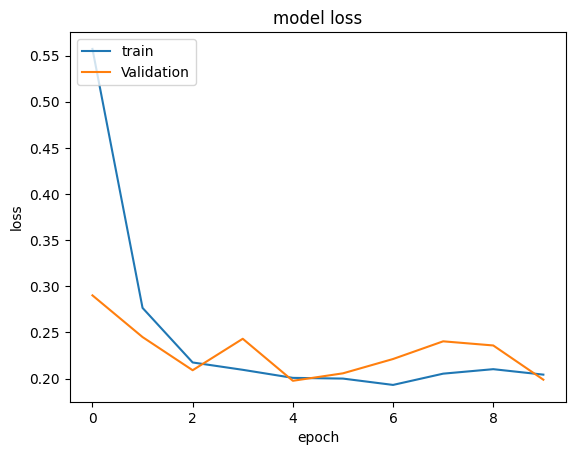

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

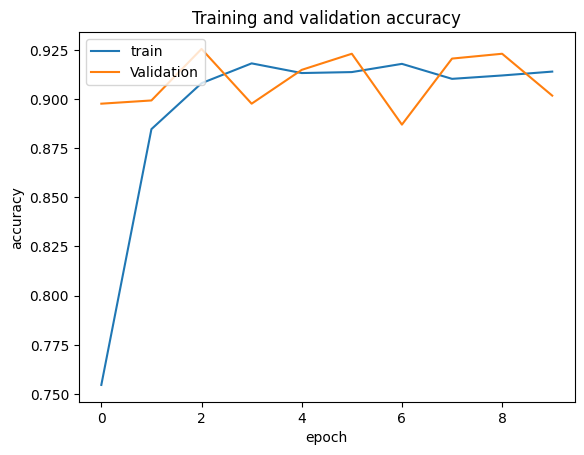

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

49/49 [==============================] - 1s 3ms/step
[[358 133   0]
 [ 55 477   0]
 [  0  27 510]]
0.8621794871794872
0.8629467510371226
              precision    recall  f1-score   support

           0       0.87      0.73      0.79       491
           1       0.75      0.90      0.82       532
           2       1.00      0.95      0.97       537

    accuracy                           0.86      1560
   macro avg       0.87      0.86      0.86      1560
weighted avg       0.87      0.86      0.86      1560



<Axes: >

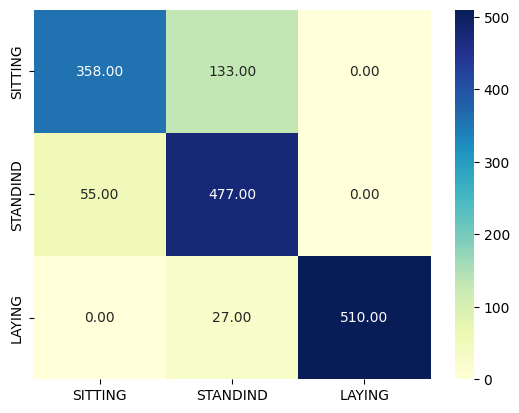

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# CNN 1 - LSTM2



In [ ]:

# define model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))

model.add(LSTM(100,return_sequences=True))
model.add(LSTM(100))

model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_29 (Conv1D)          (None, 126, 64)           1792      
                                                                 
 dropout_42 (Dropout)        (None, 126, 64)           0         
                                                                 
 max_pooling1d_22 (MaxPooli  (None, 63, 64)            0         
 ng1D)                                                           
                                                                 
 lstm_31 (LSTM)              (None, 63, 100)           66000     
                                                                 
 lstm_32 (LSTM)              (None, 100)               80400     
                                                                 
 dropout_43 (Dropout)        (None, 100)               0         
                                                     

In [ ]:

# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)


Epoch 1/10
32/32 [==============================] - 8s 42ms/step - loss: 0.5384 - accuracy: 0.7482 - val_loss: 0.3659 - val_accuracy: 0.7969
Epoch 2/10
32/32 [==============================] - 0s 13ms/step - loss: 0.2390 - accuracy: 0.9012 - val_loss: 0.2180 - val_accuracy: 0.9197
Epoch 3/10
32/32 [==============================] - 1s 18ms/step - loss: 0.2094 - accuracy: 0.9139 - val_loss: 0.3331 - val_accuracy: 0.7854
Epoch 4/10
32/32 [==============================] - 1s 16ms/step - loss: 0.1952 - accuracy: 0.9164 - val_loss: 0.2066 - val_accuracy: 0.9140
Epoch 5/10
32/32 [==============================] - 1s 17ms/step - loss: 0.2023 - accuracy: 0.9149 - val_loss: 0.2589 - val_accuracy: 0.8862
Epoch 6/10
32/32 [==============================] - 1s 16ms/step - loss: 0.2037 - accuracy: 0.9154 - val_loss: 0.2469 - val_accuracy: 0.8952
Epoch 7/10
32/32 [==============================] - 1s 17ms/step - loss: 0.1862 - accuracy: 0.9186 - val_loss: 0.2239 - val_accuracy: 0.9148
Epoch 8/10
32

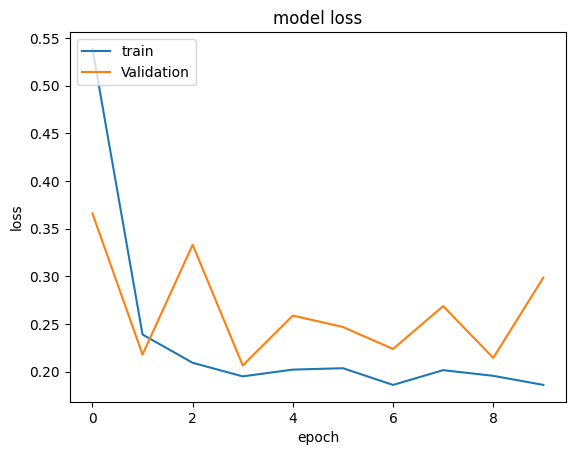

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

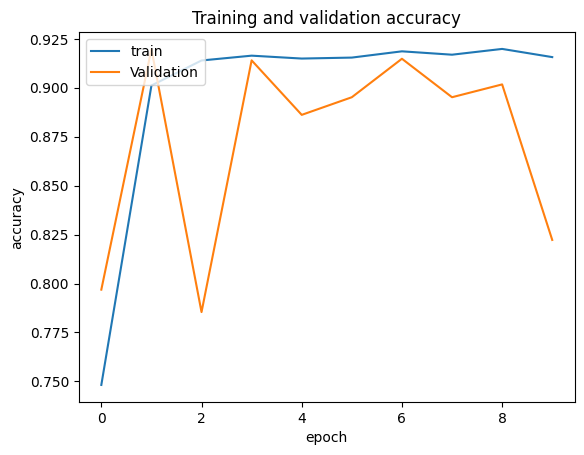

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

49/49 [==============================] - 1s 4ms/step
[[466  25   0]
 [218 314   0]
 [  0  27 510]]
0.8269230769230769
0.8234957866478354
              precision    recall  f1-score   support

           0       0.68      0.95      0.79       491
           1       0.86      0.59      0.70       532
           2       1.00      0.95      0.97       537

    accuracy                           0.83      1560
   macro avg       0.85      0.83      0.82      1560
weighted avg       0.85      0.83      0.82      1560



<Axes: >

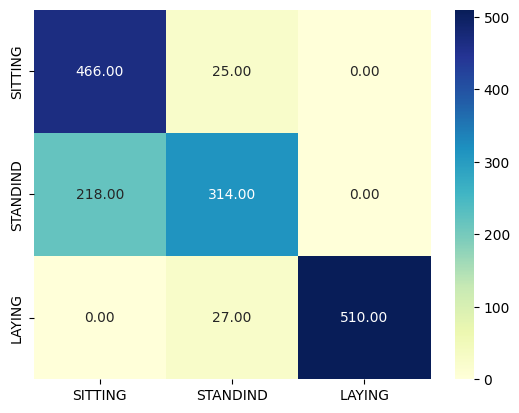

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# CNN2 - LSTM1

In [ ]:

# define model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))

model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))

model.add(LSTM(100))

model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_32 (Conv1D)          (None, 126, 64)           1792      
                                                                 
 conv1d_33 (Conv1D)          (None, 124, 64)           12352     
                                                                 
 dropout_46 (Dropout)        (None, 124, 64)           0         
                                                                 
 max_pooling1d_24 (MaxPooli  (None, 62, 64)            0         
 ng1D)                                                           
                                                                 
 lstm_34 (LSTM)              (None, 100)               66000     
                                                                 
 dropout_47 (Dropout)        (None, 100)               0         
                                                     

In [ ]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)


Epoch 1/10
32/32 [==============================] - 4s 30ms/step - loss: 0.5236 - accuracy: 0.7728 - val_loss: 0.4988 - val_accuracy: 0.7076
Epoch 2/10
32/32 [==============================] - 0s 12ms/step - loss: 0.2632 - accuracy: 0.8835 - val_loss: 0.2399 - val_accuracy: 0.8984
Epoch 3/10
32/32 [==============================] - 0s 9ms/step - loss: 0.2536 - accuracy: 0.8994 - val_loss: 0.2579 - val_accuracy: 0.8943
Epoch 4/10
32/32 [==============================] - 0s 10ms/step - loss: 0.2106 - accuracy: 0.9171 - val_loss: 0.2467 - val_accuracy: 0.8952
Epoch 5/10
32/32 [==============================] - 0s 9ms/step - loss: 0.2033 - accuracy: 0.9181 - val_loss: 0.2047 - val_accuracy: 0.9197
Epoch 6/10
32/32 [==============================] - 0s 10ms/step - loss: 0.2085 - accuracy: 0.9154 - val_loss: 0.2220 - val_accuracy: 0.9214
Epoch 7/10
32/32 [==============================] - 0s 10ms/step - loss: 0.2469 - accuracy: 0.9122 - val_loss: 0.3323 - val_accuracy: 0.7912
Epoch 8/10
32/3

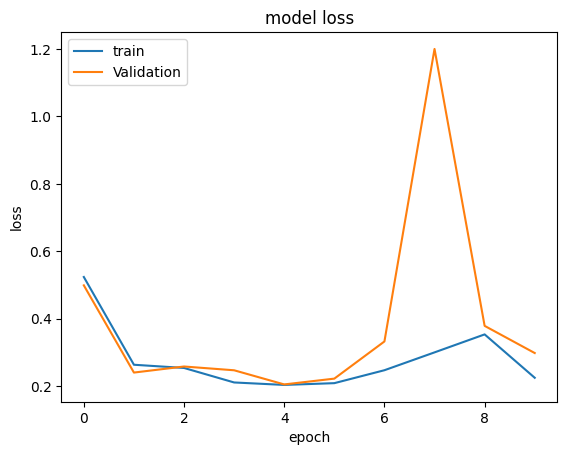

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

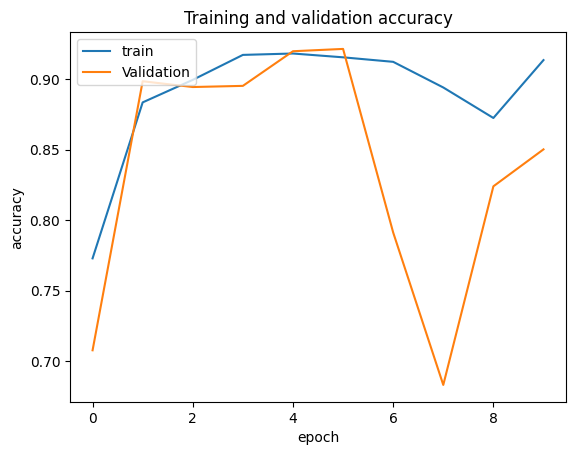

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

49/49 [==============================] - 0s 3ms/step
[[458  33   0]
 [204 328   0]
 [  0   0 537]]
0.8480769230769231
0.8447968581214876
              precision    recall  f1-score   support

           0       0.69      0.93      0.79       491
           1       0.91      0.62      0.73       532
           2       1.00      1.00      1.00       537

    accuracy                           0.85      1560
   macro avg       0.87      0.85      0.84      1560
weighted avg       0.87      0.85      0.84      1560



<Axes: >

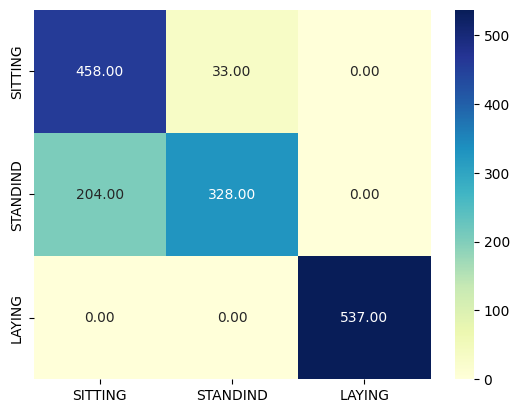

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# CNN2 - LSTM2

In [ ]:

# define model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))

model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))

model.add(LSTM(100,return_sequences=True))
model.add(LSTM(100))

model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_34 (Conv1D)          (None, 126, 64)           1792      
                                                                 
 conv1d_35 (Conv1D)          (None, 124, 64)           12352     
                                                                 
 dropout_48 (Dropout)        (None, 124, 64)           0         
                                                                 
 max_pooling1d_25 (MaxPooli  (None, 62, 64)            0         
 ng1D)                                                           
                                                                 
 lstm_35 (LSTM)              (None, 62, 100)           66000     
                                                                 
 lstm_36 (LSTM)              (None, 100)               80400     
                                                     

In [ ]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)


Epoch 1/10
32/32 [==============================] - 7s 43ms/step - loss: 0.4876 - accuracy: 0.7947 - val_loss: 0.2420 - val_accuracy: 0.8829
Epoch 2/10
32/32 [==============================] - 0s 13ms/step - loss: 0.2624 - accuracy: 0.9051 - val_loss: 0.2488 - val_accuracy: 0.9165
Epoch 3/10
32/32 [==============================] - 1s 16ms/step - loss: 0.2246 - accuracy: 0.9080 - val_loss: 0.2360 - val_accuracy: 0.8862
Epoch 4/10
32/32 [==============================] - 0s 14ms/step - loss: 0.2110 - accuracy: 0.9127 - val_loss: 0.1995 - val_accuracy: 0.9148
Epoch 5/10
32/32 [==============================] - 0s 13ms/step - loss: 0.2216 - accuracy: 0.9098 - val_loss: 0.2205 - val_accuracy: 0.9230
Epoch 6/10
32/32 [==============================] - 0s 13ms/step - loss: 0.1958 - accuracy: 0.9147 - val_loss: 0.2104 - val_accuracy: 0.9181
Epoch 7/10
32/32 [==============================] - 0s 13ms/step - loss: 0.2001 - accuracy: 0.9147 - val_loss: 0.1934 - val_accuracy: 0.9247
Epoch 8/10
32

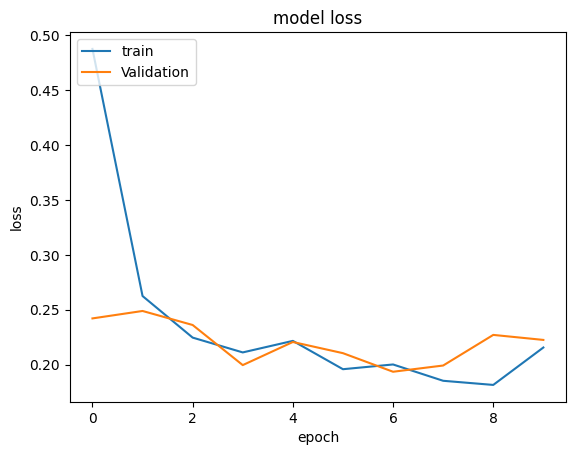

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

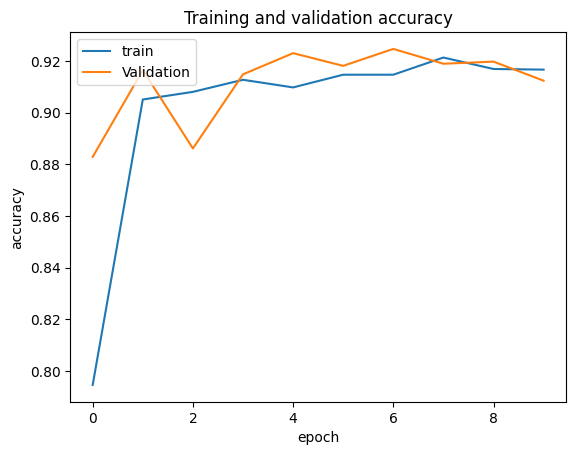

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

49/49 [==============================] - 1s 4ms/step
[[422  69   0]
 [113 419   0]
 [  0  27 510]]
0.8660256410256411
0.8672164384299307
              precision    recall  f1-score   support

           0       0.79      0.86      0.82       491
           1       0.81      0.79      0.80       532
           2       1.00      0.95      0.97       537

    accuracy                           0.87      1560
   macro avg       0.87      0.87      0.87      1560
weighted avg       0.87      0.87      0.87      1560



<Axes: >

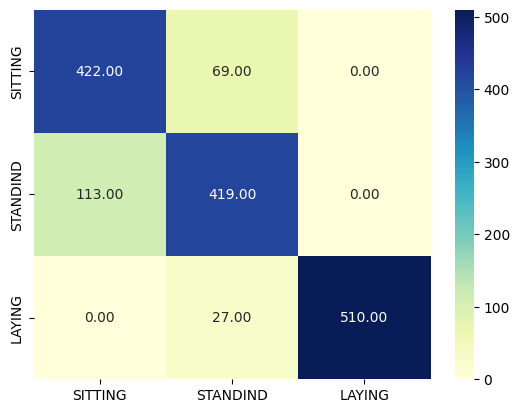

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# Timedistributed

In [ ]:
n_steps = 4
n_features = trainX.shape[2]
n_length = 32

trainX = trainX.reshape((trainX.shape[0], n_steps, n_length, n_features))
testX = testX.reshape((testX.shape[0], n_steps, n_length, n_features))
X_val = X_val.reshape((X_val.shape[0], n_steps, n_length, n_features))
print(trainX.shape,testX.shape)

(4067, 4, 32, 9) (1560, 4, 32, 9)


In [ ]:
n_timesteps, n_features, n_outputs = n_steps * n_length, trainX.shape[3], testy_one_hot.shape[1]

# CNN1 - LSTM1

In [ ]:
# Model 1
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_features)))

model.add(TimeDistributed(Dropout(0.5)))

model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))

model.add(LSTM(100))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_4 (TimeDi  (None, None, 30, 64)      1792      
 stributed)                                                      
                                                                 
 time_distributed_5 (TimeDi  (None, None, 30, 64)      0         
 stributed)                                                      
                                                                 
 time_distributed_6 (TimeDi  (None, None, 15, 64)      0         
 stributed)                                                      
                                                                 
 time_distributed_7 (TimeDi  (None, None, 960)         0         
 stributed)                                                      
                                                                 
 lstm_23 (LSTM)              (None, 100)             

In [ ]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)


Epoch 1/10
32/32 [==============================] - 5s 28ms/step - loss: 0.3756 - accuracy: 0.8439 - val_loss: 0.2086 - val_accuracy: 0.8960
Epoch 2/10
32/32 [==============================] - 0s 8ms/step - loss: 0.2147 - accuracy: 0.9075 - val_loss: 0.2024 - val_accuracy: 0.9238
Epoch 3/10
32/32 [==============================] - 0s 8ms/step - loss: 0.2019 - accuracy: 0.9125 - val_loss: 0.1990 - val_accuracy: 0.9271
Epoch 4/10
32/32 [==============================] - 0s 7ms/step - loss: 0.2002 - accuracy: 0.9181 - val_loss: 0.2068 - val_accuracy: 0.8976
Epoch 5/10
32/32 [==============================] - 0s 9ms/step - loss: 0.1929 - accuracy: 0.9176 - val_loss: 0.1876 - val_accuracy: 0.9279
Epoch 6/10
32/32 [==============================] - 0s 8ms/step - loss: 0.1924 - accuracy: 0.9130 - val_loss: 0.1942 - val_accuracy: 0.9255
Epoch 7/10
32/32 [==============================] - 0s 9ms/step - loss: 0.1851 - accuracy: 0.9216 - val_loss: 0.1946 - val_accuracy: 0.9075
Epoch 8/10
32/32 [=

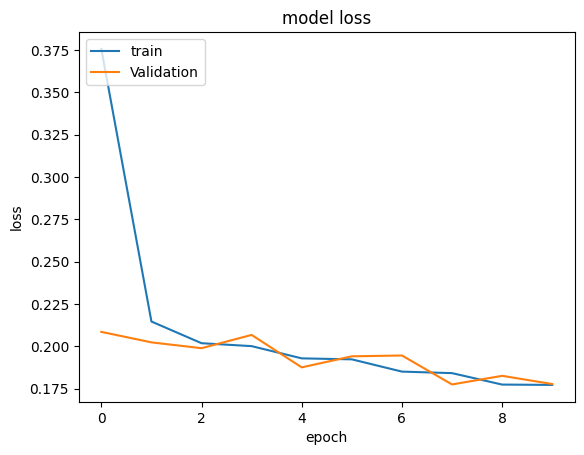

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

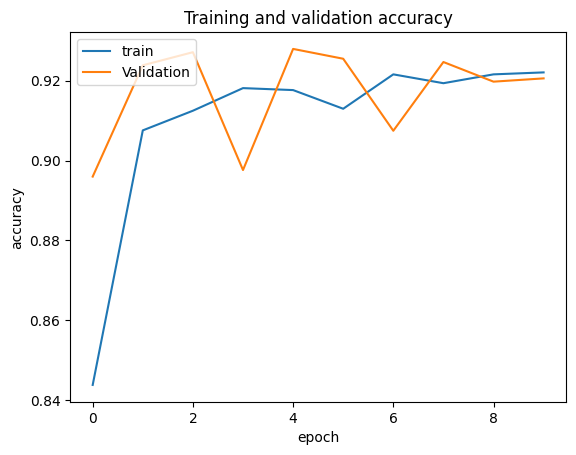

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

49/49 [==============================] - 0s 2ms/step
[[393  98   0]
 [ 75 457   0]
 [  0   3 534]]
0.8871794871794871
0.8871925154218614
              precision    recall  f1-score   support

           0       0.84      0.80      0.82       491
           1       0.82      0.86      0.84       532
           2       1.00      0.99      1.00       537

    accuracy                           0.89      1560
   macro avg       0.89      0.88      0.89      1560
weighted avg       0.89      0.89      0.89      1560



<Axes: >

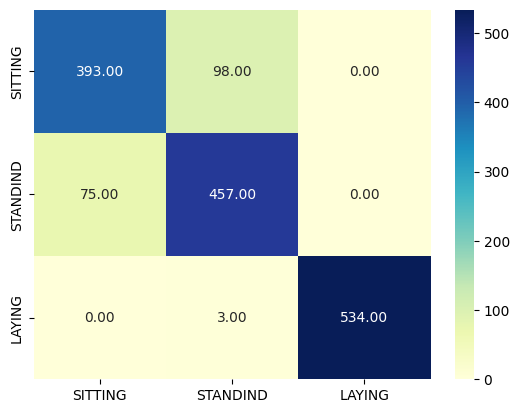

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# CNN1 - LSTM2

In [ ]:

# define model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_features)))

model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))

model.add(LSTM(100,return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(100))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_8 (TimeDi  (None, None, 30, 64)      1792      
 stributed)                                                      
                                                                 
 time_distributed_9 (TimeDi  (None, None, 30, 64)      0         
 stributed)                                                      
                                                                 
 time_distributed_10 (TimeD  (None, None, 15, 64)      0         
 istributed)                                                     
                                                                 
 time_distributed_11 (TimeD  (None, None, 960)         0         
 istributed)                                                     
                                                                 
 lstm_24 (LSTM)              (None, None, 100)       

In [ ]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)


Epoch 1/10
32/32 [==============================] - 6s 37ms/step - loss: 0.4490 - accuracy: 0.8097 - val_loss: 0.2246 - val_accuracy: 0.8845
Epoch 2/10
32/32 [==============================] - 0s 14ms/step - loss: 0.2213 - accuracy: 0.9044 - val_loss: 0.2051 - val_accuracy: 0.8968
Epoch 3/10
32/32 [==============================] - 0s 12ms/step - loss: 0.2100 - accuracy: 0.9117 - val_loss: 0.1943 - val_accuracy: 0.9034
Epoch 4/10
32/32 [==============================] - 0s 12ms/step - loss: 0.1978 - accuracy: 0.9125 - val_loss: 0.1888 - val_accuracy: 0.9107
Epoch 5/10
32/32 [==============================] - 0s 13ms/step - loss: 0.1959 - accuracy: 0.9120 - val_loss: 0.1841 - val_accuracy: 0.9214
Epoch 6/10
32/32 [==============================] - 0s 13ms/step - loss: 0.1986 - accuracy: 0.9139 - val_loss: 0.1821 - val_accuracy: 0.9206
Epoch 7/10
32/32 [==============================] - 0s 12ms/step - loss: 0.1833 - accuracy: 0.9179 - val_loss: 0.1795 - val_accuracy: 0.9091
Epoch 8/10
32

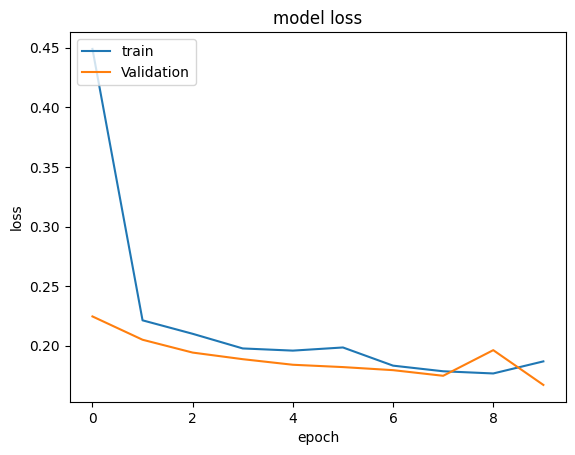

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

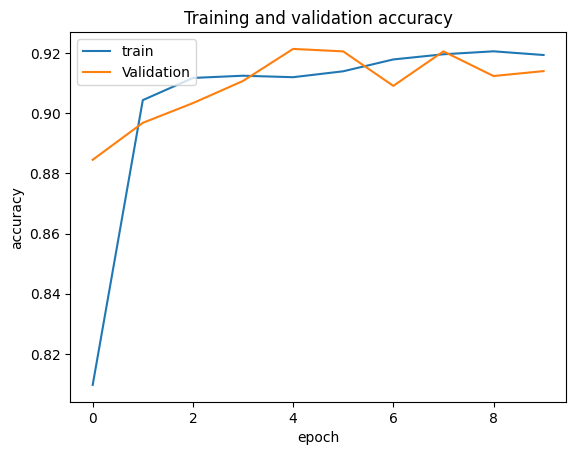

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

49/49 [==============================] - 1s 3ms/step
[[386 105   0]
 [ 82 450   0]
 [  0   1 536]]
0.8794871794871795
0.8793786047351476
              precision    recall  f1-score   support

           0       0.82      0.79      0.81       491
           1       0.81      0.85      0.83       532
           2       1.00      1.00      1.00       537

    accuracy                           0.88      1560
   macro avg       0.88      0.88      0.88      1560
weighted avg       0.88      0.88      0.88      1560



<Axes: >

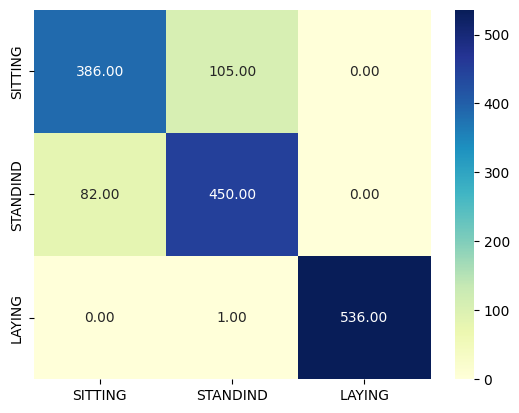

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# CNN2- LSTM1

In [ ]:

# define model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_features)))

model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))
model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))


model.add(LSTM(100))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_12 (TimeD  (None, None, 30, 64)      1792      
 istributed)                                                     
                                                                 
 time_distributed_13 (TimeD  (None, None, 28, 64)      12352     
 istributed)                                                     
                                                                 
 time_distributed_14 (TimeD  (None, None, 28, 64)      0         
 istributed)                                                     
                                                                 
 time_distributed_15 (TimeD  (None, None, 14, 64)      0         
 istributed)                                                     
                                                                 
 time_distributed_16 (TimeD  (None, None, 896)       

In [ ]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)


Epoch 1/10
32/32 [==============================] - 7s 31ms/step - loss: 0.4127 - accuracy: 0.8303 - val_loss: 0.2189 - val_accuracy: 0.8993
Epoch 2/10
32/32 [==============================] - 0s 9ms/step - loss: 0.2104 - accuracy: 0.9095 - val_loss: 0.2075 - val_accuracy: 0.9156
Epoch 3/10
32/32 [==============================] - 0s 8ms/step - loss: 0.2149 - accuracy: 0.9078 - val_loss: 0.2288 - val_accuracy: 0.8903
Epoch 4/10
32/32 [==============================] - 0s 8ms/step - loss: 0.2085 - accuracy: 0.9149 - val_loss: 0.2315 - val_accuracy: 0.9115
Epoch 5/10
32/32 [==============================] - 0s 8ms/step - loss: 0.2011 - accuracy: 0.9134 - val_loss: 0.1972 - val_accuracy: 0.9214
Epoch 6/10
32/32 [==============================] - 0s 9ms/step - loss: 0.1880 - accuracy: 0.9211 - val_loss: 0.1878 - val_accuracy: 0.9140
Epoch 7/10
32/32 [==============================] - 0s 9ms/step - loss: 0.1792 - accuracy: 0.9211 - val_loss: 0.1891 - val_accuracy: 0.9156
Epoch 8/10
32/32 [=

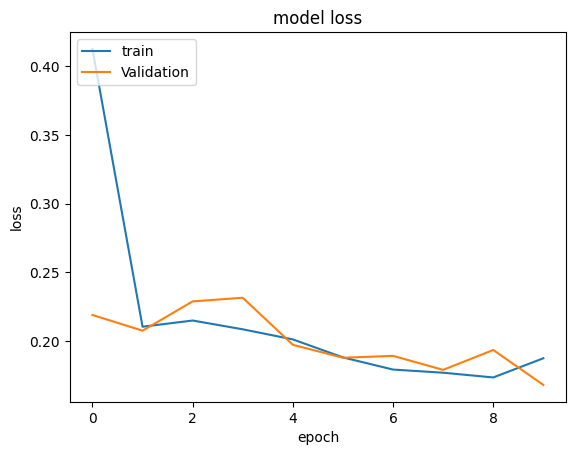

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

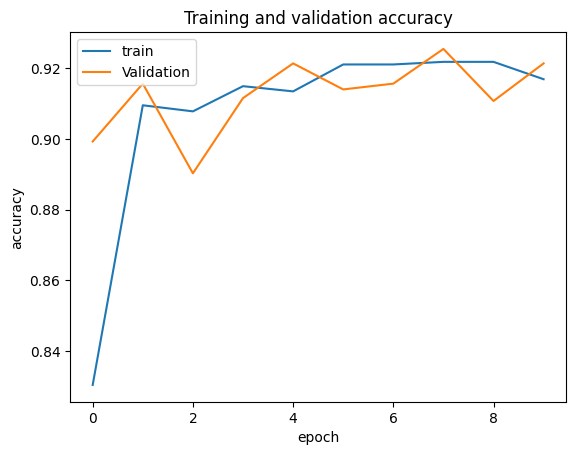

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

49/49 [==============================] - 1s 3ms/step
[[390 101   0]
 [ 90 442   0]
 [  0  27 510]]
0.8602564102564103
0.8617491082035287
              precision    recall  f1-score   support

           0       0.81      0.79      0.80       491
           1       0.78      0.83      0.80       532
           2       1.00      0.95      0.97       537

    accuracy                           0.86      1560
   macro avg       0.86      0.86      0.86      1560
weighted avg       0.86      0.86      0.86      1560



<Axes: >

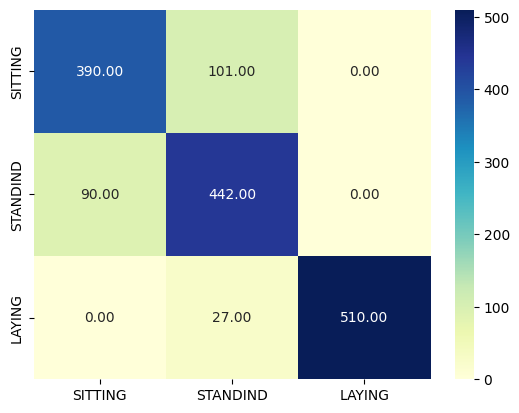

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# CNN2 -LSTM2

In [ ]:

# define model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_features)))

model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))
model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))

model.add(LSTM(100,return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(100))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_17 (TimeD  (None, None, 30, 64)      1792      
 istributed)                                                     
                                                                 
 time_distributed_18 (TimeD  (None, None, 28, 64)      12352     
 istributed)                                                     
                                                                 
 time_distributed_19 (TimeD  (None, None, 28, 64)      0         
 istributed)                                                     
                                                                 
 time_distributed_20 (TimeD  (None, None, 14, 64)      0         
 istributed)                                                     
                                                                 
 time_distributed_21 (TimeD  (None, None, 896)       

In [ ]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)


Epoch 1/10
32/32 [==============================] - 9s 36ms/step - loss: 0.4415 - accuracy: 0.8279 - val_loss: 0.2053 - val_accuracy: 0.9099
Epoch 2/10
32/32 [==============================] - 0s 10ms/step - loss: 0.2204 - accuracy: 0.9098 - val_loss: 0.1944 - val_accuracy: 0.9238
Epoch 3/10
32/32 [==============================] - 0s 10ms/step - loss: 0.2172 - accuracy: 0.9078 - val_loss: 0.2081 - val_accuracy: 0.9099
Epoch 4/10
32/32 [==============================] - 0s 9ms/step - loss: 0.2018 - accuracy: 0.9152 - val_loss: 0.1876 - val_accuracy: 0.9165
Epoch 5/10
32/32 [==============================] - 0s 10ms/step - loss: 0.1934 - accuracy: 0.9117 - val_loss: 0.1937 - val_accuracy: 0.9075
Epoch 6/10
32/32 [==============================] - 0s 10ms/step - loss: 0.1860 - accuracy: 0.9176 - val_loss: 0.1867 - val_accuracy: 0.9099
Epoch 7/10
32/32 [==============================] - 0s 9ms/step - loss: 0.1784 - accuracy: 0.9189 - val_loss: 0.1736 - val_accuracy: 0.9255
Epoch 8/10
32/3

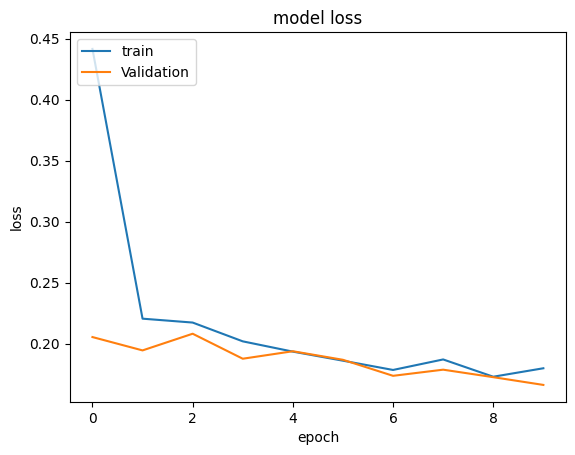

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

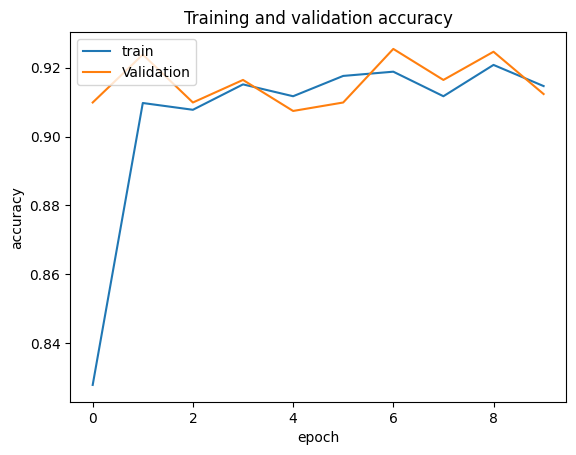

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

49/49 [==============================] - 1s 3ms/step
[[402  89   0]
 [101 431   0]
 [  0  27 510]]
0.860897435897436
0.8623763364156689
              precision    recall  f1-score   support

           0       0.80      0.82      0.81       491
           1       0.79      0.81      0.80       532
           2       1.00      0.95      0.97       537

    accuracy                           0.86      1560
   macro avg       0.86      0.86      0.86      1560
weighted avg       0.86      0.86      0.86      1560



<Axes: >

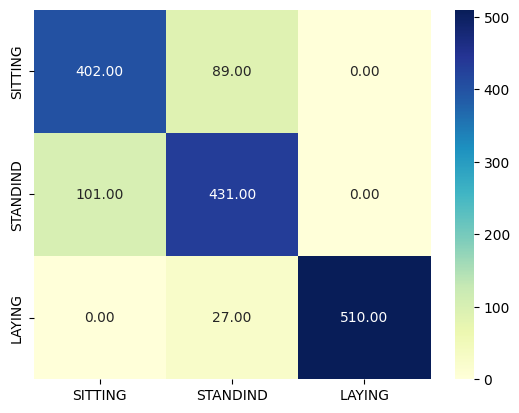

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')